In [1]:
# Import dependencies
from tqdm import tqdm
import numpy as np
import torch
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from nsynth import make_loaders
from features import MFCC, Scat1D, JTFS

# Create AcousticFeature objects

In [2]:
assert torch.cuda.is_available()
device = 'cuda'
sr = 16000
N = 4 * sr
batch_size = 2

# MFCC parameters
n_mfcc = 30
log_mels=True

# scattering transform parameters
J = 10
Q1 = 12
Q2 = 1
log2_T = J
T = 2 ** log2_T
J_fr = 5
Q_fr = 2
F = None

mfcc = MFCC(sr=sr,
            batch_size=batch_size,
            device=device,
            n_mfcc=n_mfcc,
            log_mels=log_mels)
scat = Scat1D(shape=N,
              sr=sr,
              batch_size=batch_size,
              device=device,
              J=J,
              Q=(Q1, Q2),
              T=T)
jtfst = JTFS(shape=N, 
             sr=sr,
             batch_size=batch_size,
             device=device,
             J=J, 
             Q=(Q1, Q2), 
             T=T, 
             J_fr=J_fr, 
             Q_fr=Q_fr, 
             F=F)

c:\Users\aidan\source\repos\scattering-music-gen\.venv\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


# Get dataloaders

In [20]:
data_loaders = make_loaders(subsets=['test'],
                            nbatch=4,
                            targets=['instrument_family'],
                            sources=['acoustic'])

Loading NSynth data from split test at C:\Users\aidan\source\datasets\nsynth-full\nsynth-test
	Found 1689 samples.


# Compute isomap embeddings

In [15]:
def process_data(acoustic_ft, data_loader, device='cpu'):
    X = []
    y = []
    for audio, target in tqdm(data_loader):
        audio = audio.to(device)
        fts = acoustic_ft.compute_features(audio)

        fts = fts.to('cpu')
        for i in range(len(target)):
            X.append(fts[i].numpy())
            y.append(target[i].numpy())
    X = np.array(X)
    y = np.array(y)
    return X, y


def plot_isomap(X, y, label, n_neighbors=40):
    isomap = Isomap(n_neighbors=n_neighbors,
                    n_components=3)
    embeddings = isomap.fit_transform(X)
    cmap = plt.cm.viridis

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=y, cmap=cmap)
    ax.set_xlabel('Isomap Dim 1')
    ax.set_ylabel('Isomap Dim 2')
    ax.set_zlabel('Isomap Dim 3')
    ax.set_title(f'Isomap Embeddings colored by {label}')

    plt.show()

## time scattering

In [5]:
X_scat, y_scat = process_data(acoustic_ft=scat, data_loader=data_loaders['test'], device='cuda')

100%|██████████| 212/212 [02:33<00:00,  1.38it/s]


In [6]:
print(f"# of scattering coefficients expected: {scat.transform.output_size()}")
X_scat = X_scat.squeeze()
print(X_scat.shape)
print(y_scat.shape)

# of scattering coefficients expected: 545
(1689, 545)
(1689,)


In [14]:
torch.cuda.empty_cache()

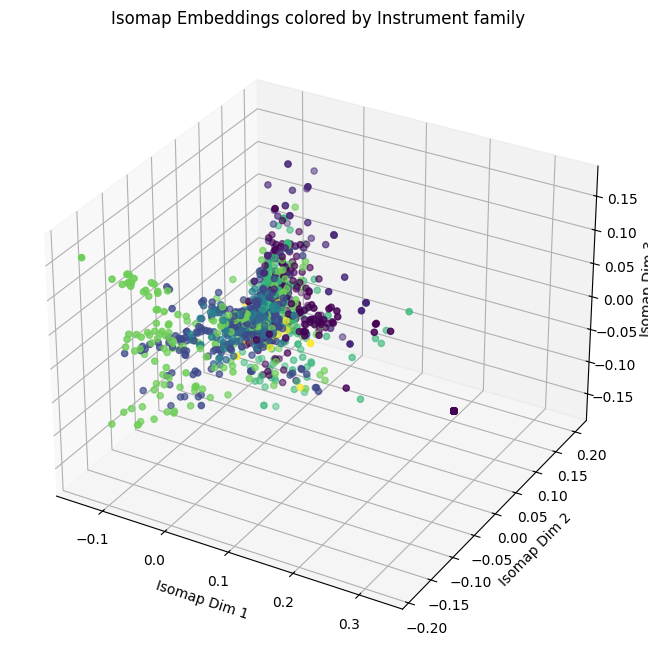

In [8]:
plot_isomap(X_scat, y_scat, "Instrument family")

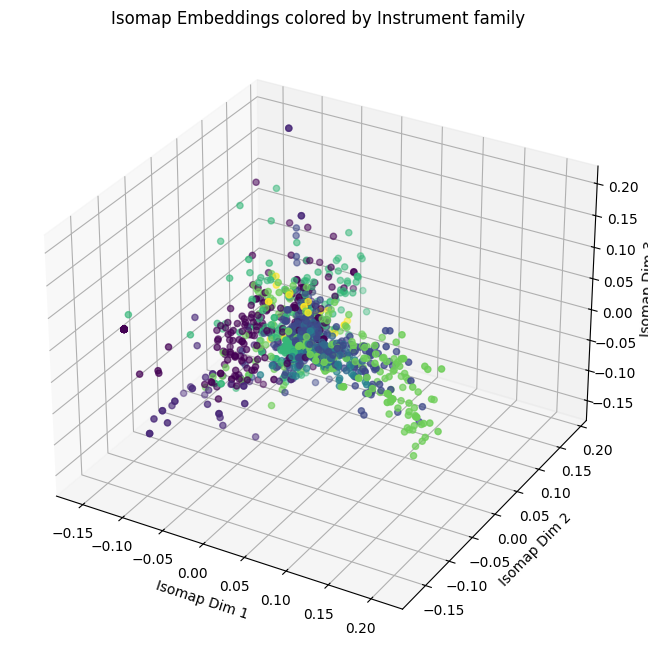

In [9]:
plot_isomap(X_scat, y_scat, "Instrument family", n_neighbors=50)

## joint time-frequency scattering

experiencing memory issues, run just a few batches on cpu and see how they look

In [22]:
jtfst_cpu = JTFS(shape=N, 
             sr=sr,
             batch_size=batch_size,
             device='cpu',
             J=J, 
             Q=(Q1, Q2), 
             T=T, 
             J_fr=J_fr, 
             Q_fr=Q_fr, 
             F=F)

In [23]:
X_jtfst = []
y_jtfst = []
loader_iter = iter(data_loaders['test'])

for _ in tqdm(range(20)):
    audio, target = next(loader_iter)
    fts = jtfst_cpu.compute_features(audio)

    for i in range(len(target)):
        X_jtfst.append(fts[i].numpy())
        y_jtfst.append(target[i].numpy())

X_jtfst = np.array(X_jtfst)
y_jtfst = np.array(y_jtfst)

  5%|▌         | 1/20 [02:05<39:42, 125.39s/it]

In [ ]:
print(f"# of scattering coefficients expected: {jtfst.transform.output_size()}")
X_jtfst = X_jtfst.squeeze()
print(X_jtfst.shape)
print(y_jtfst.shape)

# of scattering coefficients expected: 440


In [ ]:
plot_isomap(X_jtfst, y_jtfst, "Instrument family")